## Preparation

### Import nessasary libraries

In [1]:
import copy
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm
import os
import json

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.utils.data

from torchvision import models
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image

cudnn.benchmark = True
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 2080 Ti'

### Define or import functions

In [2]:
from algorithms import tensor_imshow, get_class_name, get_model, gradcam, gradrise, read_tensor

# Set the size of the input image.
input_size = (224, 224)

### Create the explainer instance

In [3]:
from algorithms import blur, auc, CausalMetric
insertion = CausalMetric(get_model(), 'ins', input_size[0], substrate_fn=blur)
deletion = CausalMetric(get_model(), 'del', input_size[0], substrate_fn=torch.zeros_like)

c:\Users\jerry2137\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
c:\Users\jerry2137\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# Execute this code if animal_list.json does not exist.

model = get_model()
animal_list = []
for animal in os.listdir('animals'):
    p = 0
    for img_name in os.listdir('animals/{}'.format(animal)):
        img = read_tensor('animals/{}/{}'.format(animal, img_name))

        probability, class_number = torch.topk(model(img.cuda()), k=1)
        probability, class_number = probability[0], class_number[0]

        if((probability.item() > 0.7) & (animal in get_class_name(class_number))):
            animal_list.append('animals/{}/{}'.format(animal, img_name))
            break # The size of the dataset will be around 50 if this line is commented out. Otherwise, around 2000. 

for i , item in enumerate(animal_list):
    print(i, item)

# Save the paths of the images.
with open('animal_list.json', 'w') as json_file:
    json.dump(animal_list, json_file)

In [4]:
# Load the selected images if animal_list.json exist.
with open('animal_list.json', 'r') as json_file:
    animal_list = json.load(json_file)
    
len(animal_list)

54

In [5]:
gradcam_sal_dict = {}
for image_path in animal_list:
    input_tensor = read_tensor(image_path)
    layer_name, gradcam_sal_flatten = gradcam(input_tensor, new_risecam=True)
    gradcam_sal_dict[image_path] = gradcam_sal_flatten

In [6]:
folder_path = './Finalized Stimuli_Correct Resolution'

scores = []

for image_path in tqdm(animal_list):
    scores_list = []
    input_tensor = read_tensor(image_path)

    six_score = []
    
    saliency_map = gradrise(input_tensor)

    deletion_sal = deletion.single_run(input_tensor, np.array(saliency_map), input_size[0]*input_size[1])
    score_deletion = auc(deletion_sal)
    score_deletion_20 = auc(deletion_sal, fraction=0.2)
    insertion_sal = insertion.single_run(input_tensor, np.array(saliency_map), input_size[0]*input_size[1])
    score_insertion = auc(insertion_sal)
    score_insertion_20 = auc(insertion_sal, fraction=0.2)
    score = score_insertion - score_deletion
    score_20 = score_insertion_20 - score_deletion_20

    scores.append([score_insertion, score_deletion, score, score_insertion_20, score_deletion_20, score_20])
scores

100%|██████████| 54/54 [3:38:24<00:00, 242.68s/it]


[[0.9909705615469387,
  0.03154484706095673,
  0.959425714485982,
  0.9652493128722365,
  0.15179754627487538,
  0.8134517665973611],
 [0.9973649084568024,
  0.2533067230027939,
  0.7440581854540085,
  0.9877413849939,
  0.9611551091074944,
  0.026586275886405608],
 [0.9635077855325237,
  0.08905572747643678,
  0.874452058056087,
  0.8600777093194086,
  0.3727169790389863,
  0.4873607302804223],
 [0.5386994847992485,
  0.08261482418556808,
  0.45608466061368036,
  0.28552925029494375,
  0.4159481802807105,
  -0.13041892998576676],
 [0.6359253180479365,
  0.06744546564576938,
  0.5684798524021671,
  0.10264597629958933,
  0.314665797251192,
  -0.21201982095160266],
 [0.6193376978127552,
  0.16659000388036457,
  0.45274769393239056,
  0.46169822002676403,
  0.6639619848944924,
  -0.2022637648677284],
 [0.9977410786918232,
  0.1057446515487592,
  0.8919964271430639,
  0.9998599995266307,
  0.4860504759390923,
  0.5138095235875384],
 [0.9332397662261168,
  0.06602800178011746,
  0.86721176

In [7]:
np.mean(scores, axis=0)

array([0.82884999, 0.12982367, 0.69902631, 0.61897245, 0.49157668,
       0.12739577])

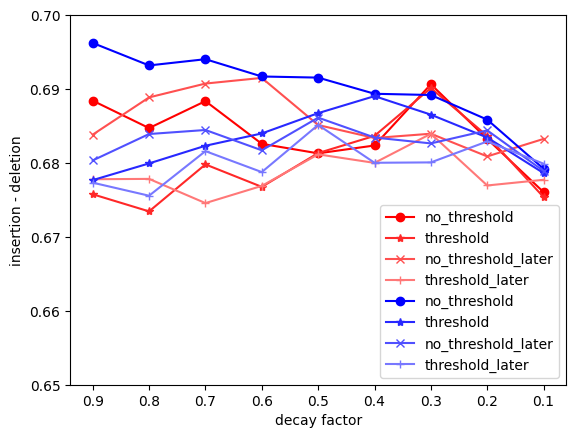

In [ ]:
markers = ['o', '*', 'x', '+']
# red: nomalize 
for i, values in enumerate(scores_dict_normalize.values()):
    plt.plot(values.values(), marker=markers[i], color=f'#ff{i * 40:02x}{i * 40:02x}')
# blue: no nomalize 
for i, values in enumerate(scores_dict_no_normalize.values()):
    plt.plot(values.values(), marker=markers[i], color=f'#{i * 40:02x}{i * 40:02x}ff')
decay_factors = [i/10 for i in range(9, 0, -1)]

plt.legend(list(scores_dict_normalize.keys()) + list(scores_dict_no_normalize.keys()))
plt.ylim(0.65, 0.70)
plt.ylabel('insertion - deletion')
plt.xticks(range(9), decay_factors)
plt.xlabel('decay factor')
plt.show()